### LVV-308 / LVV-T2846 ###
### LVV-309 / LVV-T2847 ###

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rubin_sim.maf as maf

Identify the baseline survey simulation. 

Using baseline_v3.0_10yrs as the baseline for example (this should be updated to baseline_v3.2_10yrs)

In [2]:
# Download and write to current directory, if does not exist
run_name = 'baseline_v3.0_10yrs'
dbfile = f"{run_name}.db"

url_baseline = "https://s3df.slac.stanford.edu/data/rubin/sim-data/"
url_baseline += "sims_featureScheduler_runs3.0/baseline/baseline_v3.0_10yrs.db"

if not(os.path.isfile(dbfile)):
    print(f'Downloading {run_name} from {url_baseline}')

    from urllib.request import urlopen

    with urlopen(url_baseline) as file:
        content = file.read()
    with open(dbfile, 'wb') as download:
        download.write(content)

Run SRD metrics for on-sky area and revisit timescales. 
These metrics are coded into `rubin_sim.maf`, at https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/batches/srd_batch.py

In [3]:
out_dir = 'srd_area'
results_db = maf.ResultsDb(out_dir)

fO_bundles = maf.fOBatch(colmap=None,
                            runName=run_name,
                            benchmarkArea=18000,
                            benchmarkn_visits=825,
                            minn_visits=750)
revisit_bundles = maf.rapidRevisitBatch(colmap=None,
                                        runName=run_name)

all_bundles = {}
all_bundles.update(fO_bundles)
all_bundles.update(revisit_bundles)

g = maf.MetricBundleGroup(all_bundles, dbfile, out_dir=out_dir, results_db=results_db)
g.run_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Evaluate Sky Coverage ###

In [5]:
fO = fO_bundles['baseline_v3_0_10yrs_fO_All_visits_HEAL']

{'FO': 1}

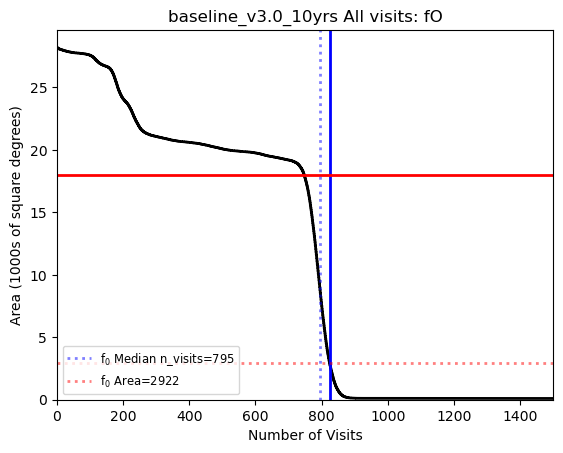

In [7]:
# Plot cumulative area covered to a minimum number of visits

fO.plot()

In this plot, the solid black line shows the amount of area observed with at least (a minimum of) X number of visits. The SRD details specify an area of sky (Asky) to be covered uniformly (see table 22), and then specifies a the *median* number of visits over Asky shall not be less than Nv1 (see table 23). 

The design goals for Asky and Nv1 are 18,000 sq degrees and 825 visits, with minimum values of 15,000 sq degrees and 750 visits. 

The solid red and blue lines above indicate SRD design values. The dotted blue line indicates the *median* number of visits over the top 18,000 sq degrees. The dotted red line indicates the area covered to a *minimum* of 825 visits per pointing. 

In [43]:
nv_med = np.where(fO.summary_values['fONv']['name'] == 'MedianNvis')[0]
nv_min = np.where(fO.summary_values['fONv']['name'] == 'MinNvis')[0]

names = ['fOArea 825', 'fOArea 750', 'fONv Median', 'fONv Minimum']
run_vals = [fO.summary_values['fOArea'], fO.summary_values['fOArea_750'], 
            fO.summary_values['fONv'][nv_med]['value'][0], fO.summary_values['fONv'][nv_min]['value'][0]]

pd.DataFrame(run_vals, names, columns=[run_name])

,baseline_v3.0_10yrs
fOArea 825,2921.581179
fOArea 750,17809.811151
fONv Median,795.000000
fONv Minimum,747.000000


While the `fOArea 750` value above measured the area covered to a minimum of 750 visits, this could be interpreted as the most satisfactory interpretation of "uniformly covered" for Asky (and we would not use 825 visits per pointing, as this is both a design goal not a minimum goal, and also intended to work with the median visits per pointing, rather than the minimum which will always be a harder requirement as it implies no single point of dropout .. which would be permissible in the median). 

Likewise, the `fONv Median` value above is the most satisfactory interpretation for the "median visits per pointing over Asky area, and here we are using 18,000 sq degrees for the area (not the minimum area). 

Both `fOArea 750` and `fONv Median` are above the SRD minimum specifications. 

### Evaluate rapid revisit 

In [45]:
revisit_1 = revisit_bundles['baseline_v3_0_10yrs_NumberOfQuickRevisits_All_visits_HEAL']

Number of consecutive visits with return times faster than 30.0 minutes, in any filter, all proposals. 


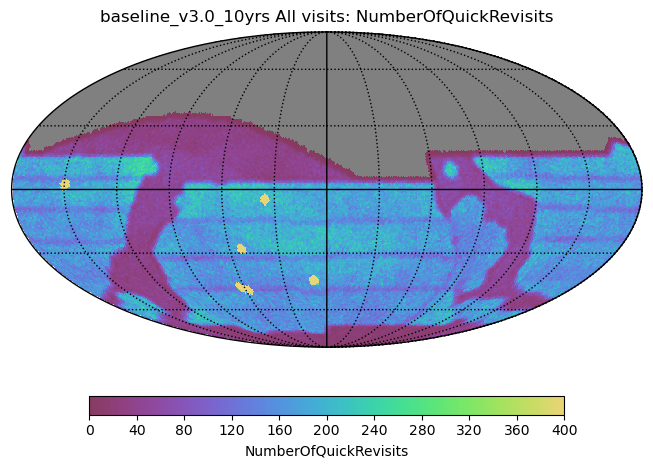

In [53]:
plot_dict = {'color_min': 0, 'color_max': 400}
revisit_1.set_plot_dict(plot_dict)
revisit_1.plot_funcs = [maf.HealpixSkyMap()]
revisit_1.plot()
print(revisit_1.display_dict['caption'])

This metric simply counts the number of return revisits per point on the sky that occur faster than 30 minutes apart (not counting snaps as 'revisits'). 

The SRD requirement in Table 25 is that there is at least RVA1 area covered 'nearly uniformly' between 40 seconds and 30 minutes -- 'nearly uniformly' here is poorly defined however and does not allow for overabundances of visits at some timescales due to pairs of visits, etc (which may still satisfy the underlying concern to 'well sample' the sky at these timescales). 

To try to encapsulate the spirit of the SRD requirement, the "RapidRevisit" metric was created, which looks for a minimum number of visits between 40 seconds and 30 minutes, with a further minimum of visits within 40 seconds minutes to 20 minutes. More visits are allowed between 20-30 minutes than in the first portion of the timeperiod, allowing for the overabundance due to pairs of visits. The metric result is 0 if that point on the sky does not satisfy the requirement, and '1' if it does. 

In [63]:
revisit_2 = revisit_bundles['baseline_v3_0_10yrs_RapidRevisits_All_visits_HEAL']

Rapid Revisit: area that receives at least 82 visits between 0.667 and 30.0 minutes, with at least 28 of those visits falling between 0.667 and 20.0 minutes. Summary statistic "Area" indicates the area on the sky which meets this requirement. (SRD design specification is 2000 sq deg).


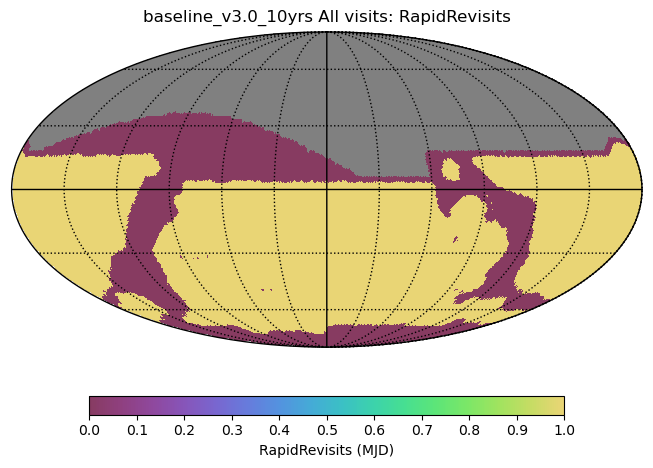

In [67]:
plot_dict = {'color_min': 0, 'color_max': 1}
revisit_2.set_plot_dict(plot_dict)
revisit_2.plot_funcs = [maf.HealpixSkyMap()]
revisit_2.plot()
print(revisit_2.display_dict['caption'])

In [68]:
revisit_2.summary_values

{'Area (sq deg)': 29072.825063298995}

This requirement is easily met by all parts of the sky currently included in the 'main survey' portion of the sky. 